# FRAUD DETECTION - EXPLORATORY DATA ANALYSIS
This Notebook contains the Exploratory Data Analysis part of the project<br>
This is the first of 2 Notebooks.

##### CONTENT

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, performance of models are measured by recall, precision, the Area Under the ROC Curve (AUC_ROC)and the Area Under the PR Curve (AUC_PR).

## DATA

### Importing Libraries

In [0]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
from pyspark.sql import functions as f
from pyspark.sql.types import FloatType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler, IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.sql.functions import col,sum

import warnings
warnings.filterwarnings("ignore")

### Importing Data

In [0]:
dataPath = "/FileStore/tables/creditcard.csv"
df = spark.read\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .csv(dataPath)

In [0]:
display(df)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0.0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,0
0.0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0
1.0,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459424895,0.066083685268831,0.717292731410831,-0.165945922763554,2.34586494901581,-2.89008319444231,1.10996937869599,-0.121359313195888,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66,0
1.0,-0.966271711572087,-0.185226008082898,1.79299333957872,-0.863291275036453,-0.0103088796030823,1.24720316752486,0.23760893977178,0.377435874652262,-1.38702406270197,-0.0549519224713749,-0.226487263835401,0.178228225877303,0.507756869957169,-0.28792374549456,-0.631418117709045,-1.0596472454325,-0.684092786345479,1.96577500349538,-1.2326219700892,-0.208037781160366,-0.108300452035545,0.00527359678253453,-0.190320518742841,-1.17557533186321,0.647376034602038,-0.221928844458407,0.0627228487293033,0.0614576285006353,123.5,0
2.0,-1.15823309349523,0.877736754848451,1.548717846511,0.403033933955121,-0.407193377311653,0.0959214624684256,0.592940745385545,-0.270532677192282,0.817739308235294,0.753074431976354,-0.822842877946363,0.53819555014995,1.3458515932154,-1.11966983471731,0.175121130008994,-0.451449182813529,-0.237033239362776,-0.0381947870352842,0.803486924960175,0.408542360392758,-0.00943069713232919,0.79827849458971,-0.137458079619063,0.141266983824769,-0.206009587619756,0.502292224181569,0.219422229513348,0.215153147499206,69.99,0
2.0,-0.425965884412454,0.960523044882985,1.14110934232219,-0.168252079760302,0.42098688077219,-0.0297275516639742,0.476200948720027,0.260314333074874,-0.56867137571251,-0.371407196834471,1.34126198001957,0.359893837038039,-0.358090652573631,-0.137133700217612,0.517616806555742,0.401725895589603,-0.0581328233640131,0.0686531494425432,-0.0331937877876282,0.0849676720682049,-0.208253514656728,-0.559824796253248,-0.0263976679795373,-0.371426583174346,-0.232793816737034,0.105914779097957,0.253844224739337,0.0810802569229443,3.67,0
4.0,1.22965763450793,0.141003507049326,0.0453707735899449,1.20261273673594,0.191880988597645,0.272708122899098,-0.00515900288250983,0.0812129398830894,0.464959994783886,-0.0992543211289237,-1.41690724314928,-0.153825826253651,-0.75106271556262,0.16737196252175,0.0501435942254188,-0.443586797916727,0.00282051247234708,-0.61198733994012,-0.0455750446637976,-0.21963255278686,-0.167716265815783,-0.270709726172363,-0.154103786809305,-0.780055415004671,0.75013693580659,-0.257236845917139,0.0345074297438413,0.00516776890624916,4.99,0
7.0,-0.644269442348146,1.41796354547385,1.0743803763556,-0.492199018495015,0.948934094764157,0.428118462833089,1.12063135838353,-3.80786423873589,0.615374730667027,1.24937617815176,

In [0]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [0]:
# temp_table_name = "creditcard_csv"

# # Register spark SQL tables
# df.createOrReplaceTempView(temp_table_name)

# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

# permanent_table_name = "creditcard_csv"
#df.write.format("parquet").saveAsTable(permanent_table_name)

## EDA

### Summary Statistics

In [0]:
# Checking the number of rows and columns
print(f"The dimension of the dataset is:  \n {df.count()} rows \n {len(df.columns)} columns")

The dimension of the dataset is:  
 284807 rows 
 31 columns


In [0]:
summary = df.describe()

In [0]:
display(summary)

summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
mean,94813.85957508067,9.516248586879277E-16,-4.151383611725859E-17,-1.3156692677161953E-15,1.4976914722303291E-15,8.941441625255696E-16,1.3971002539462024E-15,-2.6664656275316093E-16,1.528826849318273E-16,-2.2894481447166985E-15,2.176532506335261E-15,1.8074485571052584E-15,-1.2837355476259963E-15,1.8042551850962386E-15,9.899453227961663E-16,4.972080218043971E-15,1.4585726651198355E-15,-4.0715493115003616E-16,1.2214647934501085E-15,1.0039163253356284E-15,4.770099438473463E-16,3.718282533002536E-16,-4.630389413078843E-16,2.9858028284335985E-16,4.504351011597839E-15,7.153153300204557E-16,1.6364035688721307E-15,-3.568593220079729E-16,-1.2593860860572196E-16,88.34961925093698,0.001727485630620034
stddev,47488.145954566266,1.9586958038574889,1.6513085794769968,1.5162550051777701,1.4158685749409217,1.3802467340314388,1.332271089757576,1.2370935981826656,1.194352902669203,1.09863208922432,1.0888497654025182,1.0207130277115588,0.9992013895301411,0.9952742301251545,0.9585956112570638,0.9153160116104386,0.87625288738837,0.8493370636743882,0.8381762095288418,0.8140405007685789,0.7709250248871173,0.734524014371313,0.725701560440911,0.6244602955949902,0.6056470678271607,0.5212780705409428,0.48222701326105727,0.4036324949650301,0.3300832641602508,250.12010924018836,0.041527189635464895
min,0.0,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,-13.4340663182301,-24.5882624372475,-4.79747346479757,-18.6837146333443,-5.79188120632084,-19.2143254902614,-4.49894467676621,-14.1298545174931,-25.1627993693248,-9.49874592104677,-7.21352743017759,-54.497720494566,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0
max,172792.0,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,15.5949946071278,23.7451361206545,12.0189131816199,7.8483920756446,7.12688295859376,10.5267660517847,8.87774159774277,17.3151115176278,9.25352625047285,5.04106918541184,5.59197142733558,39.4209042482199,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1


#### Columns Distribution Visulization

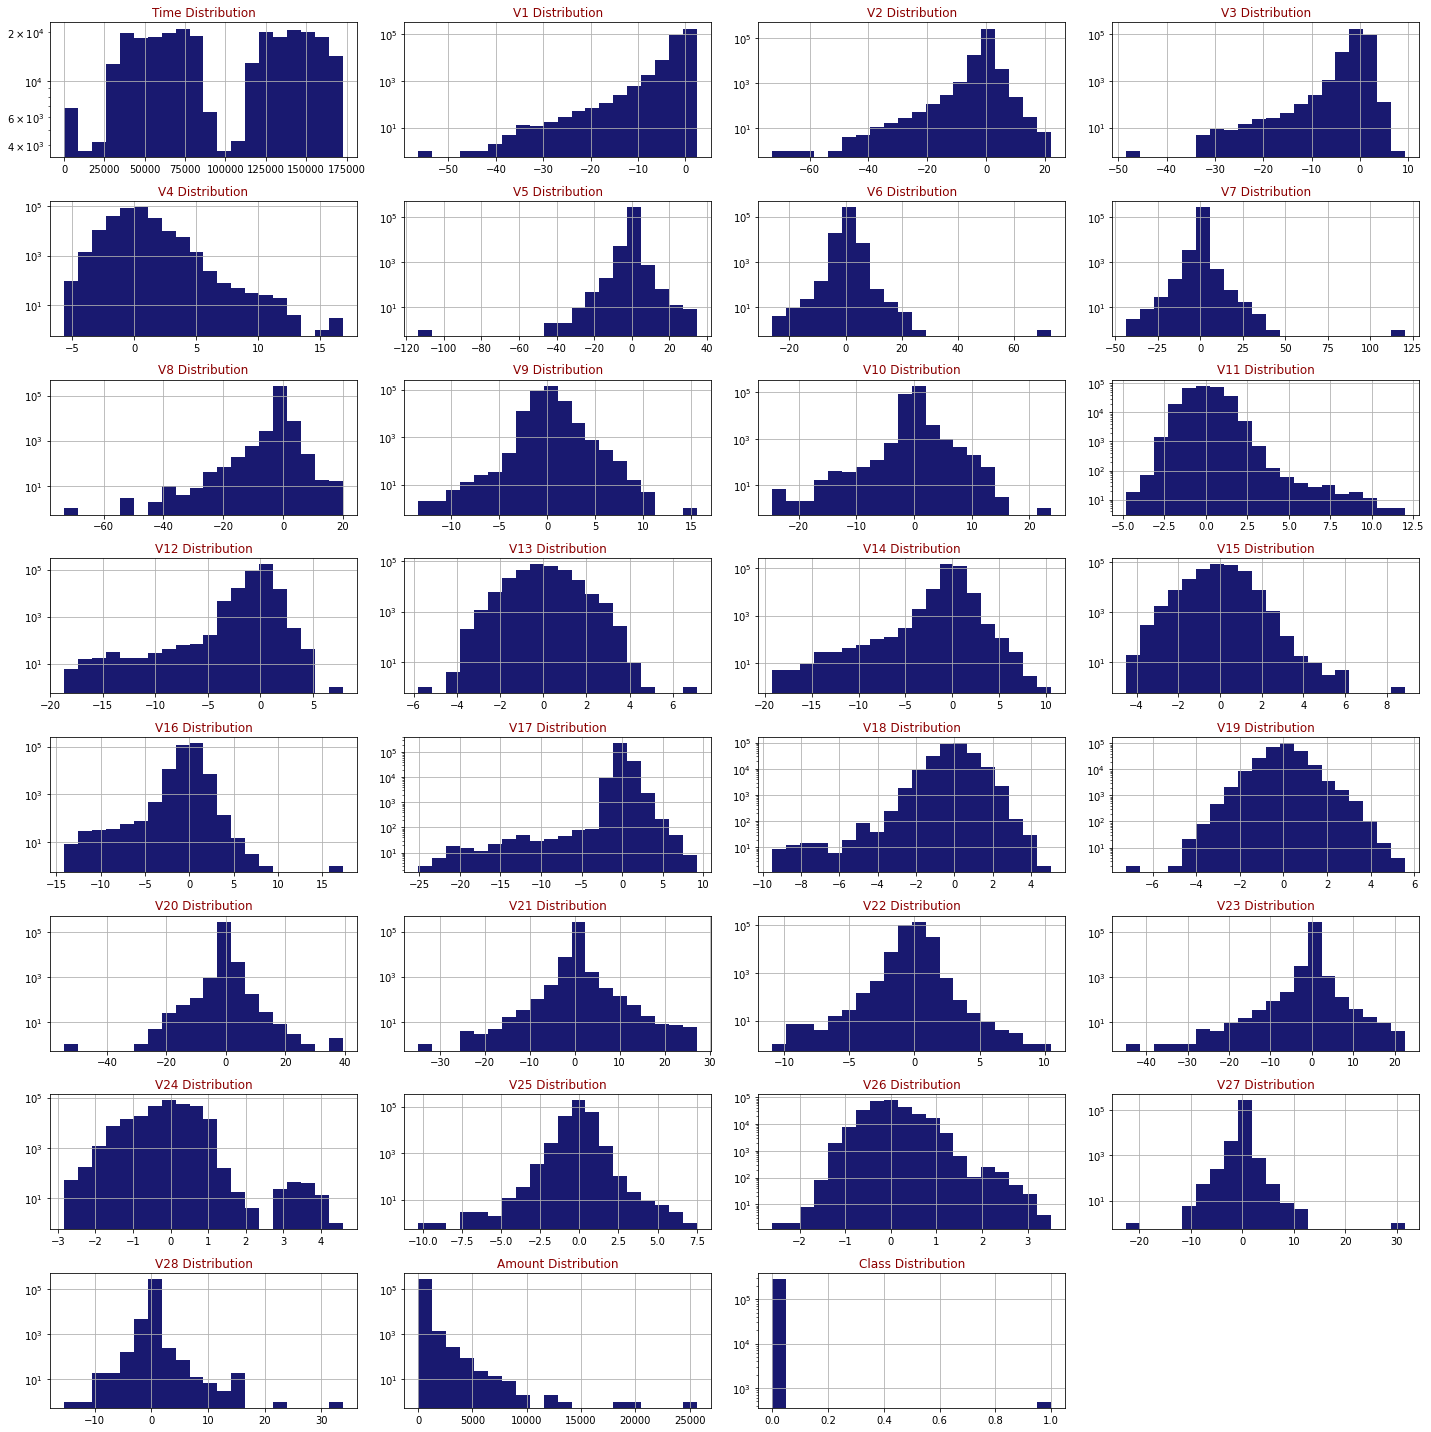

In [0]:
df1=df.select("*").toPandas()
def draw_histograms(dataframe, features, rows, cols):
    
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(df1,df1.columns,8,4)

In [0]:
df.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



#### Estimating each No. of Target feature "Class"

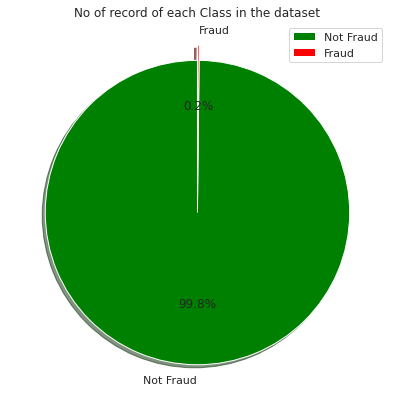

In [0]:
sns.set(style="whitegrid")
titles = ['Not Fraud', 'Fraud']
data = df1['Class'].value_counts(sort = True)

colors = ["Green","red"]
explode = (0,0.1) 
 
plt.figure(figsize=(7,7))
plt.pie(data, explode=explode, labels=titles, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('No of record of each Class in the dataset')
plt.legend()
plt.show()

In [0]:
print("Percentage of fraudulent transactions: 0.17%")

Percentage of fraudulent transactions: 0.17%


#### Dollar Amount of Fraudulent Transactions

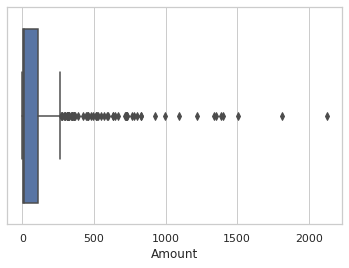

In [0]:
fraud = df1.loc[df1['Class'] == 1]
plt.tight_layout()
sns.boxplot(x=fraud['Amount'], data=fraud)
plt.show()

#### Correlation Matrix

In [0]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

#matrix.collect()[0]["pearson({})".format(vector_col)].values
numeric_variables = df.columns

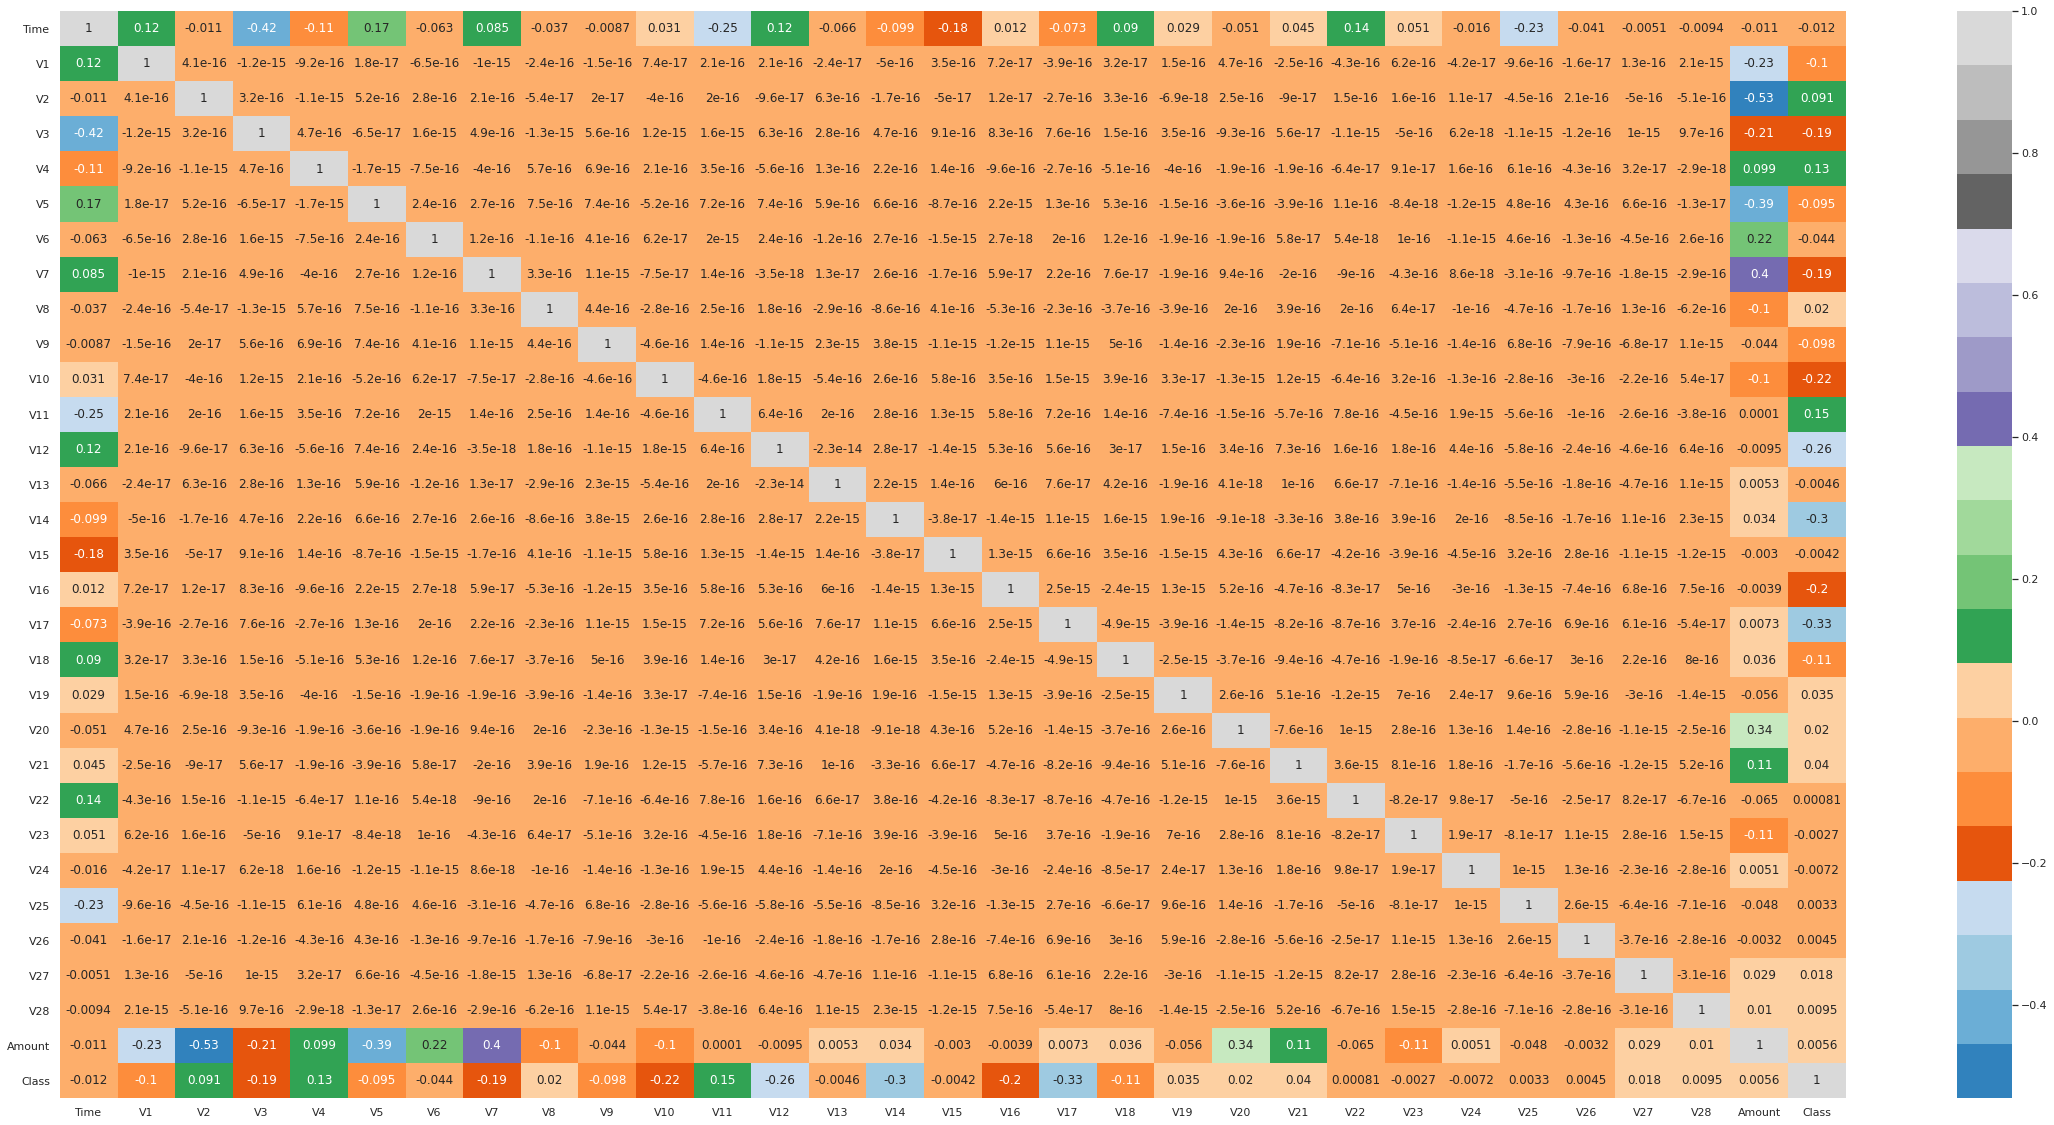

In [0]:
plt.figure(figsize = (40,20))
sns.heatmap(df1.corr(), annot = True, cmap="tab20c")
plt.show()

#### Features Density Plot

<Figure size 432x288 with 0 Axes>

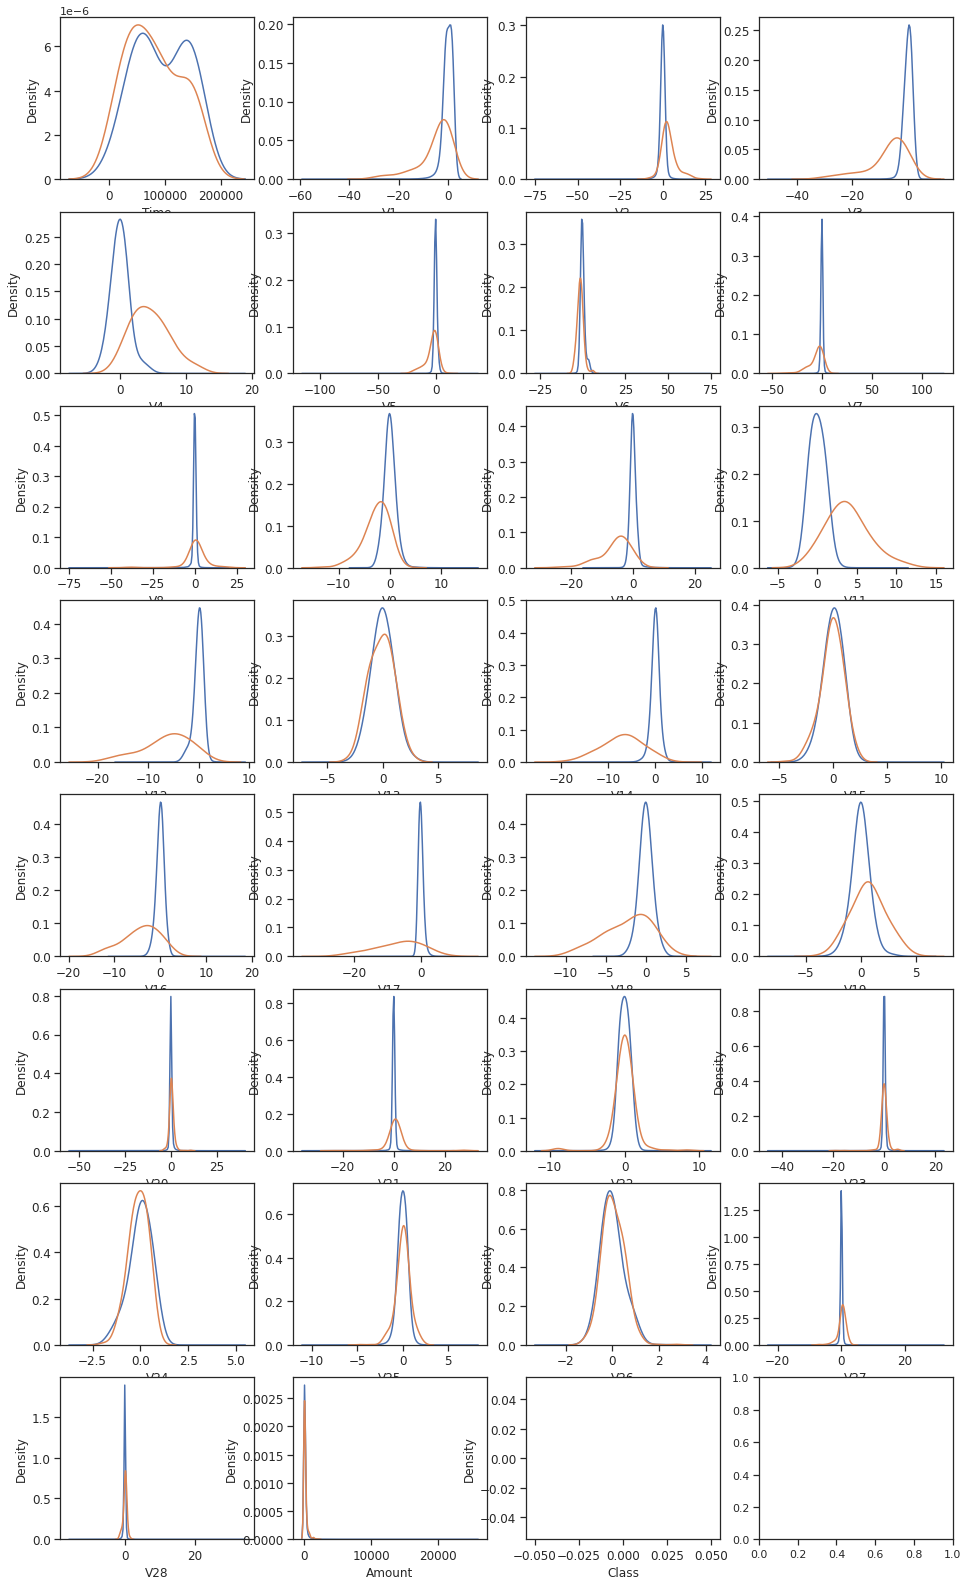

In [0]:
variables = df1.columns.values

i = 0
t0 = df1.loc[df1['Class'] == 0]
t1 = df1.loc[df1['Class'] == 1]

sns.set_style('ticks')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for dffeature in variables:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[dffeature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[dffeature], bw=0.5,label="Class = 1")
    plt.xlabel(dffeature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

## CLEANING & PREPARING

We aren't interested in the Time feature so we're going to drop it.<br>
The dataset only contains numerical values, so we don't need to apply any 'categorical' data transformation.<br>
The dataset has 284,315 non-fraudulent transactions and 492 fraudulent ones.<br>
The rate of fraudulent transactions is 0.17% which is very imbalanced and needs to be handled before begining modeling.<br>
If we use the dataset in the state it is at the moment, we will run into overfitting, where potentially many fraudulent transactions go unnoticed. We applied undersampling to correct for the data imbalance.

In [0]:
# Dropping the Time column
df = df.drop('Time')

#### Missing Values
There are no missing values in this dataset.

In [0]:
null_values = df.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in df.columns])

In [0]:
display(null_values)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Splitting Data
Now we split the dataset 75-25 for training and testing purposes.<br>
Our target feature is the Class column and it has 2 unique values, 1 for fraudulant transactions and 0 for non-fraudulent transactions.

In [0]:
df_train, df_test = df.randomSplit([0.75, 0.25], seed=123)

# Caching the data
df_train.cache()
df_test.cache()

print("Number ot Training data: " + str(df_train.count()))
print("Number ot Test data: " + str(df_test.count()))

Number ot Training data: 214074
Number ot Test data: 70733


### Data Balancing
We used the oversampling method to correct for the data imbalance.<br>
Thr altenative would have been to use undersampling, but given that there is a fairly small number of fraudulent transactions, undersampling would leave us with a very small dataset for the modeling, which would lead to weak models.

In [0]:
major_df_train = df_train.filter(f.col("Class") == 0)
minor_df_train = df_train.filter(f.col("Class") == 1)
ratio = int(major_df_train.count()/minor_df_train.count())

In [0]:
# There are 571 non-fraudulent transactions for each fraudulent transaction
print("In the training set, for every fraudulent transaction there are {}".format(ratio),'non-fraudulent transactions.')

In the training set, for every fraudulent transaction there are 576 non-fraudulent transactions.


In [0]:
a = range(70)
# Duplicate the minority rows
oversampled_df = minor_df_train.withColumn("dummy", f.explode(f.array([f.lit(x) for x in a]))).drop('dummy')

# Combine both oversampled minority rows and previous majority rows 
balanced_df_train = major_df_train.unionAll(oversampled_df)

In [0]:
balanced_df_train.groupBy("Class").count().withColumn("%", col('count')/balanced_df_train.count()*100).show()

+-----+------+------------------+
|Class| count|                 %|
+-----+------+------------------+
|    0|213703|  89.1644031659803|
|    1| 25970|10.835596834019686|
+-----+------+------------------+



In [0]:
df_test.groupBy("Class").count().withColumn("%", col('count')/df_test.count()*100).show()

+-----+-----+------------------+
|Class|count|                 %|
+-----+-----+------------------+
|    1|  121|0.1710658391415605|
|    0|70612| 99.82893416085844|
+-----+-----+------------------+



### Estimating each No. of Target feature "Class" after Balancing

### Looking for Outliers

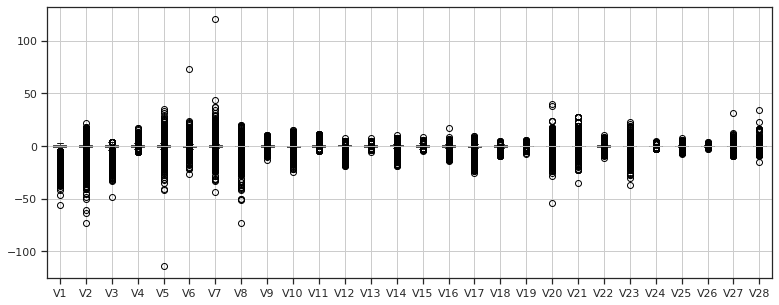

In [0]:
dfrecords_train=df_train.select("*").toPandas()
dfrecords_train.drop(['Amount','Class'],axis=1).boxplot(figsize=(13,5));

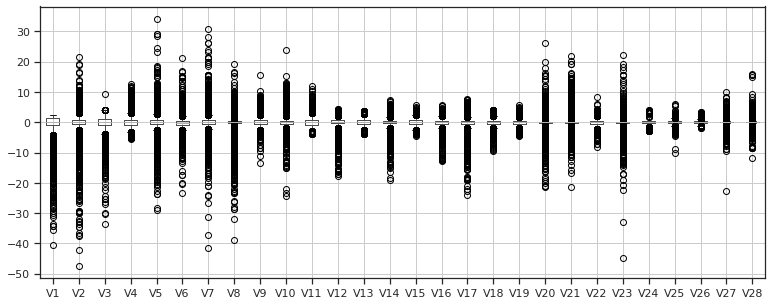

In [0]:
dfrecords_test=df_test.select("*").toPandas()
dfrecords_test.drop(['Amount','Class'],axis=1).boxplot(figsize=(13,5));

## Modelling